In [2]:
# imports needed and set up logging
import gzip
import gensim 
import logging
import glob, os
import math
import numpy as np

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [3]:
import os,sys
sys.path.insert(0,"/home/msykulski/workspace/genXone/hackyeah2019/jupyter_init_workspace/src/")

import multiprocmap
from multiprocmap import parmap

In [54]:
data_file2=["/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/0**/*",]

In [ ]:
%%time 


def read_input(input_file_list):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file_list))
    files=[file for input_file in input_file_list for file in glob.glob(input_file)]
    def line_generator(file):
        with open(file, 'rb') as f:
            #filenames.append(file)
            for i, line in enumerate (f): 
            #if (i%10000==0):
                #logging.info ("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
                yield gensim.utils.simple_preprocess (line)
            yield ["GXO_EOF","GXO_EOF","GXO_EOF","GXO_EOF","GXO_EOF"]
    all_lines=lambda file:(file,[l for l in line_generator(file)])
    #all_f_l=parmap(all_lines)
    return parmap(all_lines,files)
    

all_f_l = read_input(data_file2)

documents2_org = [f_l[1] for f_l in all_f_l]
filenames_org = [f_l[0] for f_l in all_f_l]

logging.info ("Done reading data file")    

In [ ]:
print(len(filenames_org))
documents2=[g for l in documents2_org for g in l]

In [ ]:
%%time
model = gensim.models.Word2Vec (documents2, size=150, window=10, min_count=1, workers=188)
model.train(documents2,total_examples=len(documents2),epochs=10)

In [ ]:
%%time
#model.save("model_1_5_gensim")
model = gensim.models.Word2Vec.load("model_1_15_gensim")

In [ ]:
w1 = ["polite"]
model.wv.most_similar(positive=w1,topn=10)

In [ ]:
model.wv.most_similar_cosmul(positive=w1,topn=10) #using the multiplicative combination objective

In [ ]:
%%time
def vectors_creator(file):
    with open(file, 'rb') as f:
        word_list=[]
        vec_list=[]
        #sum_list=np.zeros(150)
        count=0
        for line in f: 
            word_list+=gensim.utils.simple_preprocess(line)
        for i in word_list:
            count+=1
            vec_list.append(model.wv.get_vector(i)) #vector

        q1=sum(vec_list[:math.ceil(count/4)])
        q2=sum(vec_list[math.ceil(count/4):math.ceil(count/2)])
        q3=sum(vec_list[math.ceil(count/2):math.ceil(3*count/4)])
        q4=sum(vec_list[math.ceil(3*count/4):])
        q1_234=q1-(q2+q3+q4)
        q12_34=(q1+q2)-(q3+q4)
        q123_4=(q1+q2+q3)-q4
        sum_vec=sum(vec_list)
        if count==0:
            return (file,[])
        return (file,np.concatenate((sum_vec/count,q1_234, q12_34, q123_4)))
    
#files_vectors=[]
#files=[file for file in glob.glob(data_file2)]
files=[file for input_file in data_file2 for file in glob.glob(input_file)]
all_f_fv=parmap(vectors_creator,files)

filenames=[f_fv[0] for f_fv in all_f_fv if len(f_fv[1])>0 ]
files_vectors=[f_fv[1] for f_fv in all_f_fv if len(f_fv[1])>0 ]

#    toadd=vectors_creator(file)
#    if len(toadd)!=0:
#        files_vectors.append(toadd)

    

In [68]:
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
%%time
X=np.array(files_vectors)
P=X[1]
#print(len(X))
#print(len(X[1]))
kmeans = KMeans(n_clusters=150, random_state=0).fit(X) #,n_jobs=60).fit(X)

In [ ]:
centers = kmeans.cluster_centers_
#print(kmeans.labels_)
labels, counts = np.unique(kmeans.labels_[kmeans.labels_>=0], return_counts=True)
df=np.c_[labels[np.argsort(-counts)[:]],counts[np.argsort(-counts)[:]]] #,np.mod(range(len(counts)),3)]
print(df)
#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
print(len(filenames))
print(len(kmeans.labels_))

Text(0.5, 0, 'Log10(cluster_size)')

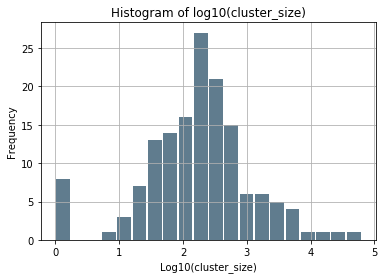

In [89]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(np.log10(df[:,1]))
commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of log10(cluster_size)')
plt.xlabel('Log10(cluster_size)')
#plt.grid(axis='y', alpha=0.75)

Text(0.5, 0, 'cluster_size')

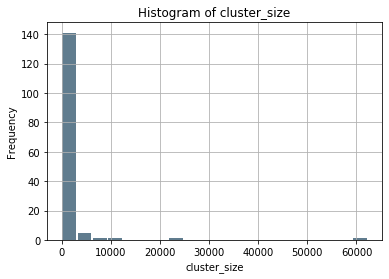

In [90]:
commutes = pd.Series(df[:,1])
commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of cluster_size')
plt.xlabel('cluster_size')

In [72]:
import pickle
filename="kmeans_1_15_wo_count_division"

pickle.dump(kmeans, open(filename, 'wb'))

#kmeans = pickle.load(open(filename, 'rb'))

In [ ]:
fset=set(np.asarray(filenames)[np.where(kmeans.labels_==10)[0].tolist()])
#[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
[open(f).readlines() for f in fset]

In [3]:
#centers_descr=[]
#centers_descr.append((78,["code","javascript"]))

In [ ]:
model.save("model_1_15_gensim")
#model = gensim.models.Word2Vec.load("model_1_15_gensim")

In [217]:
import pickle
filename="kmeans_1_15_wo_count_division"

pickle.dump(kmeans, open(filename, 'wb'))

#kmeans = pickle.load(open(filename, 'rb'))